In [1]:
import torch
import os
import tqdm

import sys
sys.path.append("../../..")
from utils.checkpoint import save_ckpt_template as save_ckpt, load_ckpt_template as load_ckpt

if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.backends.cudnn.benchmark = True   # 加速卷积计算
else:
    device = torch.device('cpu')

print(device)

cuda


In [ ]:
from data.septimbre.data import Instruments
dataset = Instruments(
    folder = '../../../data/septimbre/multi_large_256',
    mix = 1,
    input = '.wav',
    output = '.npy'
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=18, shuffle=True, pin_memory=True, num_workers=4)
print("训练集大小: ", len(dataset))
input, label = dataset[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)

val = Instruments(
    folder = '../../../data/septimbre/multi_medium_256',
    mix = 1,
    input = '.wav',
    output = '.npy'
)
valloader = torch.utils.data.DataLoader(val, batch_size=18, shuffle=False, pin_memory=True, num_workers=4)
print("测试集大小: ", len(val))
input, label = val[0]
print("输入大小: ", input.shape)
print("输出大小: ", label.shape)

# CQT配置
from model.config import CONFIG
s_per_frame = CONFIG.s_per_frame
_model = None

训练集大小:  8316
输入大小:  torch.Size([1, 1, 230400])
输出大小:  torch.Size([1, 84, 900])
测试集大小:  720
输入大小:  torch.Size([1, 1, 230400])
输出大小:  torch.Size([1, 84, 900])


In [3]:
# 从分体开始
from basicamt_nolog import BasicAMT_nL, BasicAMT_all_nL
_model = BasicAMT_nL().to(device)
optimizer = torch.optim.AdamW(_model.parameters(), lr=2e-4)
checkpoint_path = "basicamt.pth"

# 加载最佳模型
states = load_ckpt(_model, optimizer, "best_" + checkpoint_path)
if not states:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt.pth'
epoch: 6, loss: 3244.1349833984377, min_loss: 3913.303150512695


In [ ]:
from basicamt_nolog import BasicAMT_all_nL
if _model is not None:
    model = BasicAMT_all_nL(CONFIG.CQT, _model.state_dict(), CQTlearnable=False).to(device)
    print("model initialized from BasicAMT")
else:
    model = BasicAMT_all_nL(CONFIG.CQT, CQTlearnable=False).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=2, threshold=1e-3)
checkpoint_path = "basicamt_all.pth"
loss_path = "basicamt_all.loss.txt"
min_loss = float('inf')
epoch_now = 0

model initialized from BasicAMT


In [5]:
# 加载上一轮模型参数
states = load_ckpt(model, optimizer, checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No checkpoint loaded. Training from scratch.")

Checkpoint file 'basicamt_all.pth' does not exist.
No checkpoint loaded. Training from scratch.


In [6]:
model = torch.compile(model)

In [7]:
epoch_total = 50
stage_save_interval = 40    # save checkpoint every $stage_save_interval$ epochs

optimizer.zero_grad()
for epoch in range(epoch_now+1, epoch_total):
    # training
    model.train()
    train_loss = 0
    virtual_batch = 0
    for (input, target) in tqdm.tqdm(dataloader):
        input = input.to(device)    # input: (batch, mix, 2, time)
        target = target.to(device)  # target: (batch, mix, 7 * 12, 660)

        # 由于basicamt的目标没有分离音色，因此mix仅仅是数据增强的手段
        if dataset.mix > 1:
            mixed = torch.mean(input, dim=1, keepdim=False)  # 混合后的CQT
            midi_mixed, _ = target.max(dim=-3, keepdim=False)
        else:
            mixed = input.squeeze(dim=1)
            midi_mixed = target.squeeze(dim=1)

        mixed = mixed + torch.randn_like(mixed) * 0.005   # 加入噪声 经过听觉和可视化觉得0.005是一个合适的值
        # midi_mixed: (batch, 7 * 12, 660)

        onset, note = model(mixed)
        # onset & note: (batch, 7 * 12, 660)
        loss = BasicAMT_nL.loss(onset, note, midi_mixed)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= len(dataloader)

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for (input, target) in tqdm.tqdm(valloader):
            input = input.to(device)
            target = target.to(device)

            if val.mix > 1:
                mixed = torch.sum(input, dim=1, keepdim=False)
                midi_mixed, _ = target.max(dim=-3, keepdim=False)
            else:
                mixed = input.squeeze(dim=1)
                midi_mixed = target.squeeze(dim=1)

            onset, note = model(mixed)
            loss = BasicAMT_nL.loss(onset, note, midi_mixed)
            val_loss += loss.item()

        val_loss /= len(valloader)
    
    final_loss = val_loss * 0.85 + train_loss * 0.15
    schedular.step(final_loss)

    # save checkpoint
    checkpoint_filename = f"epoch{epoch}.pth" if epoch % stage_save_interval == 0 else checkpoint_path
    save_ckpt(epoch, model, min_loss, final_loss, optimizer, checkpoint_filename)
    if final_loss < min_loss:
        min_loss = final_loss

    print(f"====> Epoch: {epoch} Average train loss: {train_loss:.4f}; Average val loss: {val_loss:.4f}")
    with open(loss_path, 'a') as f:
        f.write(f"{epoch}:\ttrain_loss: {train_loss:.4f}\tval_loss: {val_loss:.4f}\n")
    epoch_now = epoch

100%|██████████| 40/40 [00:03<00:00, 12.30it/s]


====> Epoch: 1 Average train loss: 7955.7566; Average val loss: 6996.8607


100%|██████████| 40/40 [00:01<00:00, 38.20it/s]


====> Epoch: 2 Average train loss: 6595.5718; Average val loss: 6355.2651


100%|██████████| 40/40 [00:01<00:00, 37.82it/s]


====> Epoch: 3 Average train loss: 6220.1223; Average val loss: 6226.9693


100%|██████████| 40/40 [00:01<00:00, 37.60it/s]


====> Epoch: 4 Average train loss: 6006.3914; Average val loss: 5969.2869


100%|██████████| 40/40 [00:01<00:00, 35.16it/s]


====> Epoch: 5 Average train loss: 5853.6905; Average val loss: 5834.7459


100%|██████████| 40/40 [00:01<00:00, 37.63it/s]


====> Epoch: 6 Average train loss: 5735.4187; Average val loss: 5734.0954


100%|██████████| 40/40 [00:01<00:00, 37.35it/s]


====> Epoch: 7 Average train loss: 5648.1660; Average val loss: 5645.7168


100%|██████████| 40/40 [00:01<00:00, 37.01it/s]


====> Epoch: 8 Average train loss: 5572.1883; Average val loss: 5539.5385


100%|██████████| 40/40 [00:01<00:00, 37.30it/s]


====> Epoch: 9 Average train loss: 5486.8138; Average val loss: 5480.5663


100%|██████████| 40/40 [00:01<00:00, 35.98it/s]


====> Epoch: 10 Average train loss: 5433.1645; Average val loss: 5414.7542


100%|██████████| 40/40 [00:01<00:00, 35.83it/s]


====> Epoch: 11 Average train loss: 5371.4108; Average val loss: 5423.7348


100%|██████████| 40/40 [00:01<00:00, 35.12it/s]


====> Epoch: 12 Average train loss: 5325.4802; Average val loss: 5366.5697


100%|██████████| 40/40 [00:01<00:00, 35.30it/s]


====> Epoch: 13 Average train loss: 5276.5046; Average val loss: 5270.5789


100%|██████████| 40/40 [00:01<00:00, 35.24it/s]


====> Epoch: 14 Average train loss: 5238.0140; Average val loss: 5274.2075


100%|██████████| 40/40 [00:01<00:00, 35.13it/s]


====> Epoch: 15 Average train loss: 5196.9593; Average val loss: 5198.2337


100%|██████████| 40/40 [00:01<00:00, 32.85it/s]


====> Epoch: 16 Average train loss: 5163.5523; Average val loss: 5237.8025


100%|██████████| 40/40 [00:01<00:00, 35.46it/s]


====> Epoch: 17 Average train loss: 5127.8832; Average val loss: 5160.1666


100%|██████████| 40/40 [00:01<00:00, 35.29it/s]


====> Epoch: 18 Average train loss: 5096.9627; Average val loss: 5182.3508


100%|██████████| 40/40 [00:01<00:00, 34.73it/s]


====> Epoch: 19 Average train loss: 5070.8289; Average val loss: 5170.3417


100%|██████████| 40/40 [00:01<00:00, 35.11it/s]


====> Epoch: 20 Average train loss: 5043.9775; Average val loss: 5094.7651


100%|██████████| 40/40 [00:01<00:00, 34.74it/s]


====> Epoch: 21 Average train loss: 5015.7130; Average val loss: 5150.3471


100%|██████████| 40/40 [00:01<00:00, 34.90it/s]


====> Epoch: 22 Average train loss: 4990.2713; Average val loss: 5007.6131


100%|██████████| 40/40 [00:01<00:00, 34.76it/s]


====> Epoch: 23 Average train loss: 4976.6908; Average val loss: 4989.7281


100%|██████████| 40/40 [00:01<00:00, 34.51it/s]


====> Epoch: 24 Average train loss: 4957.9120; Average val loss: 5022.2936


100%|██████████| 40/40 [00:01<00:00, 34.61it/s]


====> Epoch: 25 Average train loss: 4934.7452; Average val loss: 5002.2919


100%|██████████| 40/40 [00:01<00:00, 34.33it/s]


====> Epoch: 26 Average train loss: 4905.7080; Average val loss: 5129.7066


100%|██████████| 40/40 [00:01<00:00, 34.21it/s]


====> Epoch: 27 Average train loss: 4839.4195; Average val loss: 4885.9731


100%|██████████| 40/40 [00:01<00:00, 34.76it/s]


====> Epoch: 28 Average train loss: 4832.9800; Average val loss: 4901.0561


100%|██████████| 40/40 [00:01<00:00, 34.69it/s]


====> Epoch: 29 Average train loss: 4823.2752; Average val loss: 4907.4063


100%|██████████| 40/40 [00:01<00:00, 35.13it/s]


====> Epoch: 30 Average train loss: 4815.1591; Average val loss: 4868.3459


100%|██████████| 40/40 [00:01<00:00, 33.55it/s]


====> Epoch: 31 Average train loss: 4811.9241; Average val loss: 4853.8855


100%|██████████| 40/40 [00:01<00:00, 33.93it/s]


====> Epoch: 32 Average train loss: 4803.3656; Average val loss: 4893.5540


100%|██████████| 40/40 [00:01<00:00, 33.21it/s]


====> Epoch: 33 Average train loss: 4798.2457; Average val loss: 4837.9365


100%|██████████| 40/40 [00:01<00:00, 34.48it/s]


====> Epoch: 34 Average train loss: 4790.6528; Average val loss: 4866.8521


100%|██████████| 40/40 [00:01<00:00, 34.01it/s]


====> Epoch: 35 Average train loss: 4786.6871; Average val loss: 4840.3767


100%|██████████| 40/40 [00:01<00:00, 35.05it/s]


====> Epoch: 36 Average train loss: 4782.4808; Average val loss: 4831.9733


100%|██████████| 40/40 [00:01<00:00, 34.81it/s]


====> Epoch: 37 Average train loss: 4774.2896; Average val loss: 4839.3471


100%|██████████| 40/40 [00:01<00:00, 34.62it/s]


====> Epoch: 38 Average train loss: 4767.3881; Average val loss: 4823.9294


100%|██████████| 40/40 [00:01<00:00, 33.31it/s]


====> Epoch: 39 Average train loss: 4763.6275; Average val loss: 4819.4411


100%|██████████| 40/40 [00:01<00:00, 34.21it/s]


====> Epoch: 40 Average train loss: 4756.8630; Average val loss: 4811.2002


100%|██████████| 40/40 [00:01<00:00, 34.53it/s]


====> Epoch: 41 Average train loss: 4750.9447; Average val loss: 4813.6660


100%|██████████| 40/40 [00:01<00:00, 34.27it/s]


====> Epoch: 42 Average train loss: 4745.3156; Average val loss: 4857.7766


100%|██████████| 40/40 [00:01<00:00, 33.90it/s]


====> Epoch: 43 Average train loss: 4739.4972; Average val loss: 4782.9928


100%|██████████| 40/40 [00:01<00:00, 34.64it/s]


====> Epoch: 44 Average train loss: 4732.7531; Average val loss: 4792.5704


100%|██████████| 40/40 [00:01<00:00, 33.98it/s]


====> Epoch: 45 Average train loss: 4730.5775; Average val loss: 4777.2830


100%|██████████| 40/40 [00:01<00:00, 34.64it/s]


====> Epoch: 46 Average train loss: 4731.0175; Average val loss: 4863.9832


100%|██████████| 40/40 [00:01<00:00, 33.30it/s]


====> Epoch: 47 Average train loss: 4722.5323; Average val loss: 4783.3473


100%|██████████| 40/40 [00:01<00:00, 33.55it/s]


====> Epoch: 48 Average train loss: 4717.0991; Average val loss: 4785.4684


100%|██████████| 40/40 [00:01<00:00, 32.16it/s]

====> Epoch: 49 Average train loss: 4692.2036; Average val loss: 4768.6365


In [8]:
model.cqt.cqt_kernels.requires_grad

False

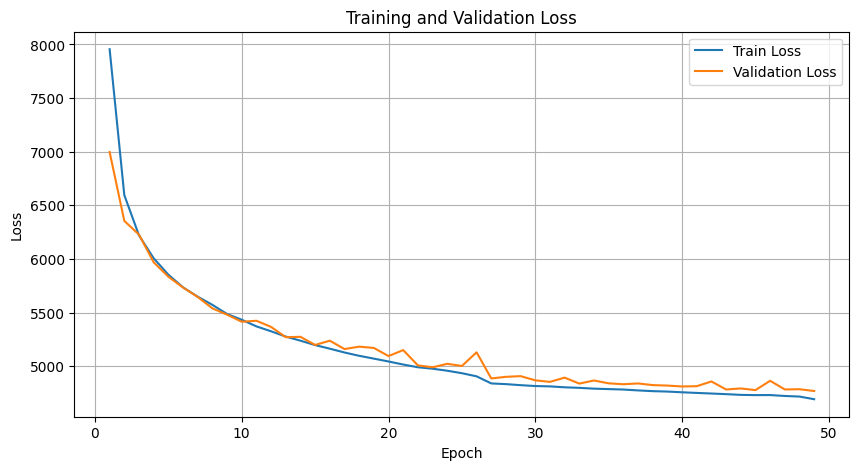

In [9]:
# 绘制训练和验证损失曲线
import matplotlib.pyplot as plt

epochs = []
train_losses = []
val_losses = []

with open(loss_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        epoch = int(parts[0].split(':')[0])
        train_loss = float(parts[1].split(': ')[1])
        val_loss = float(parts[2].split(': ')[1])
        
        epochs.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 测试模型

In [10]:
# 加载最佳模型
states = load_ckpt(model, optimizer, "best_" + checkpoint_path)
if states:
    min_loss, avg_loss, epoch_now = states
else:
    print("No best checkpoint loaded.")

Checkpoint loaded from 'best_basicamt_all.pth'
epoch: 49, loss: 4757.171581452604, min_loss: 4770.277181424228


In [11]:
# 切换到cpu 因为benchmark会导致初次运行时间长
device = torch.device('cpu')
model = model.to(device)
torch.backends.cudnn.benchmark = False

Sample rate: 22050
Channels: 2
Sample width: 2
Number of frames: 2902528
Duration (s): 131.63392290249433
data num: 5805056
torch.Size([1, 2, 2902528])


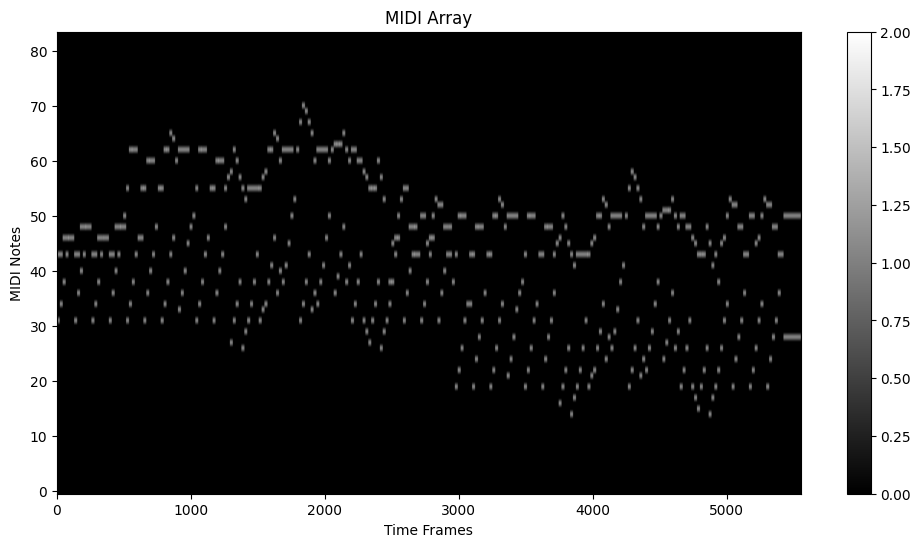

(84, 5556)


In [12]:
# 读取音频
import torchaudio
from utils.midiarray import midi2numpy
from utils.wavtool import waveInfo
import matplotlib.pyplot as plt
import numpy as np

# test_wave_path = "../../../data/inferMusic/piano_short.wav"
test_wave_path = "../../../data/inferMusic/孤独な巡礼simple.wav"
waveInfo(test_wave_path)

waveform, sample_rate = torchaudio.load(test_wave_path, normalize=True)
waveform = waveform.unsqueeze(0)
print(waveform.shape)

test_midi_path = test_wave_path.replace('.wav', '.mid')
s_per_frame = 256 / 22050
midi_array = midi2numpy(test_midi_path, s_per_frame)
plt.figure(figsize=(12, 6))
plt.imshow(midi_array, aspect='auto', origin='lower', cmap='gray')
plt.colorbar()
plt.title('MIDI Array')
plt.xlabel('Time Frames')
plt.ylabel('MIDI Notes')
plt.show()
print(midi_array.shape)

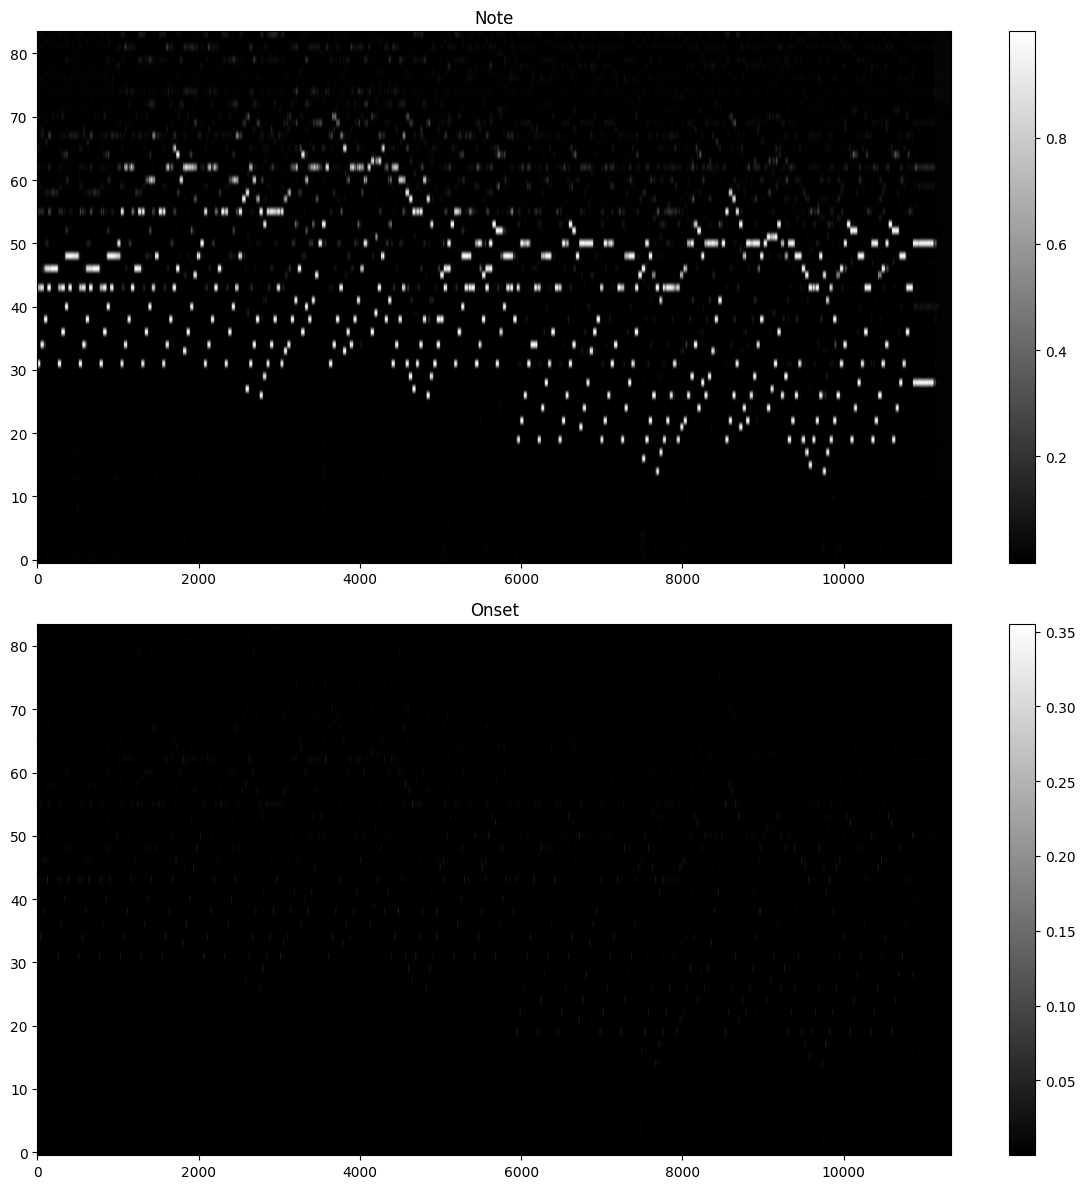

In [13]:
model.eval()
with torch.no_grad():
    onset, note = model(waveform)
    onset = onset.cpu().numpy()[0]
    note = note.cpu().numpy()[0]
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 1, 1)
    plt.title('Note')
    plt.imshow(note, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.subplot(2, 1, 2)
    plt.title('Onset')
    plt.imshow(onset, aspect='auto', origin='lower', cmap='gray')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

In [14]:
# final model to be used by others
torch.save(model, "basicamt_model.pth")